# Adsorbate Fingerprints Setup

In this tutorial we will featurize adsorbates on slabs.

For doing machine learning, we need numeric data in a matrix, where the rows represent data point or observations and columns represent the features or variables.

CatLearn contains a simple and easily extendable module for converting atoms to data, which is introduced in the following.

In [23]:
# Import packages.
import os
import numpy as np

import ase.io
from ase.data import atomic_numbers, chemical_symbols
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.visualize import view

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    plot = True
except ImportError:
    print('Seaborn module is needed for this tutorial.')

# Plot setups.
plt.rc('text', usetex=False)
font = {'family': 'sans-serif',
        # 'sans-serif':, 'Helvetica',
        'style': 'normal',
        'stretch': 'normal'}
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.rc('figure')
plt.rc('lines', markeredgewidth=0, markersize=8, linewidth=1)
ticksize = 10
plt.rc('xtick', labelsize=ticksize+2)
plt.rc('ytick.major', size=4, width=1)
plt.rc('ytick.minor', size=4, width=1)
plt.rc('ytick', labelsize=ticksize+2)
plt.rc('ytick.major', size=4, width=1)
plt.rc('ytick.minor', size=4, width=1)

### Generate some adsorbate/surface systems from ASE.

We return the atoms objects in a list, which is the simplest format and easily transferable to CatLearn.

In [24]:
"""Make a list of atoms objects."""
# Import default atomic radii.
from catlearn.featurize.periodic_table_data import get_radius, default_catlearn_radius

# Select elements for adsorbates and slabs.
adsorbates = ['H', 'O', 'C', 'N', 'S', 'Cl', 'F']
symbols = ['Ag', 'Au', 'Cu', 'Pt', 'Pd', 'Ir', 'Rh', 'Ni', 'Co']
images = []
for i, s in enumerate(symbols):

    # Get atomic radius.
    rs = get_radius(atomic_numbers[s])
    a = 2 * rs * 2 ** 0.5

    for ads in adsorbates:
        # Create a slab.
        atoms = fcc111(s, (2, 2, 3), a=a)
        atoms.center(vacuum=6, axis=2)
        
        # Constrain the slab.
        c_atoms = [a.index for a in atoms if
                   a.z < atoms.cell[2, 2] / 2. + 0.1]
        atoms.set_constraint(FixAtoms(c_atoms))

        # Specify an adsorbate-surface bond distance.
        h = (default_catlearn_radius(atomic_numbers[ads]) + rs) / 2 ** 0.5

        # Adsorb.
        add_adsorbate(atoms, ads, h, 'bridge')

        # Make list of atoms objects.
        images.append(atoms)
print(len(images), ' atoms objects created.')

63  atoms objects created.


Here we have our list of atoms stored in `images`.

### Attach meta data automatically.

The adsorbate fingerprinter generates data based on connectivity of atoms in the adsorbate/slab system. 
It therefore needs this connectivity metadata as intermediates between the atoms object and the fingerprint. A connectivity matrix can some times be slightly computationally time consuming to generate and therefore needs to be made only once.

A list of raw atoms without the metadata can be feed through `autogen_info` to attach the connectivity matrix and metadata.

In [26]:
from catlearn.featurize.adsorbate_prep import autogen_info

images = autogen_info(images)

100%|██████████| 63/63 [00:00<00:00, 60633.58it/s]
63it [00:00, 123477.17it/s]


Now let's go ahead and generate our fingerprint matrix.

First we instantiate the `FeatureGenerator` object and define the fingerprinting functions we want to call. These define what information we retrieve and include in our fingerprints.

In [27]:
from catlearn.featurize.setup import FeatureGenerator, default_fingerprinters

# Instantiate the feature generator.
fingerprint_generator = FeatureGenerator(nprocs=1)

# We will choose two example feature sets.
feature_functions = [# Average properties of atoms in the adsorption site.
                     fingerprint_generator.mean_site,
                     # A categorical encoding of which atoms are in the adsorbate.
                     fingerprint_generator.bag_atoms_ads]

There are many more fingerprint functions implemented in CatLearn, which you can see at
https://catlearn.readthedocs.io/en/latest/catlearn.fingerprint.html

Return the fingerprint matrix from atoms objects and feature_functions

In [28]:
# Get the data.
data_matrix = fingerprint_generator.return_vec(images, feature_functions)

# Get a list of names of the features.
feature_names = fingerprint_generator.return_names(feature_functions)

  0%|          | 0/63 [00:00<?, ?it/s]/Users/jagt/Git-hub/CatLearn/catlearn/fingerprint/adsorbate.py:186: RuntimeWarning: Mean of empty slice
  result = list(np.nanmean(dat, axis=0))
100%|██████████| 63/63 [00:00<00:00, 1308.47it/s]


We are done. The data matrix is now stored in the variable `data_matrix`.

You can easily append your very own fingerprint like so:

In [29]:
# Define a fingerprint function.
def bag_cn(atoms=None):
    """Fingerprinter functions must accept an atoms object and return a list."""
    if atoms is None:
        return ['my_feature']
    else:
        return [np.random.normal()]

feature_functions = [# As above.
                     fingerprint_generator.mean_site,
                     fingerprint_generator.bag_atoms_ads,
                     # Append a user defined function.
                     ]

# Get the data.
data_matrix = fingerprint_generator.return_vec(images, feature_functions)

# Get a list of names of the features.
feature_names = fingerprint_generator.return_names(feature_functions)

  0%|          | 0/63 [00:00<?, ?it/s]/Users/jagt/Git-hub/CatLearn/catlearn/fingerprint/adsorbate.py:186: RuntimeWarning: Mean of empty slice
  result = list(np.nanmean(dat, axis=0))
100%|██████████| 63/63 [00:00<00:00, 1719.35it/s]


### Let's analyse the output.

First lets see what features were returned by the `feature_functions`:

In [30]:
for l in range(len(feature_names)):
    print(l, feature_names[l])

0 atomic_number_site_av
1 atomic_volume_site_av
2 boiling_point_site_av
3 density_site_av
4 dipole_polarizability_site_av
5 electron_affinity_site_av
6 group_id_site_av
7 lattice_constant_site_av
8 melting_point_site_av
9 period_site_av
10 vdw_radius_site_av
11 covalent_radius_cordero_site_av
12 en_allen_site_av
13 atomic_weight_site_av
14 atomic_radius_site_av
15 heat_of_formation_site_av
16 dft_bulk_modulus_site_av
17 dft_density_site_av
18 dbcenter_site_av
19 dbfilling_site_av
20 dbwidth_site_av
21 dbskew_site_av
22 dbkurt_site_av
23 oxi_min_site_av
24 oxi_med_site_av
25 oxi_max_site_av
26 sblock_site_av
27 pblock_site_av
28 dblock_site_av
29 fblock_site_av
30 ne_outer_site_av
31 ne_s_site_av
32 ne_p_site_av
33 ne_d_site_av
34 ne_f_site_av
35 ionenergy_site_av
36 ground_state_magmom_site_av
37 bag_ads_H
38 bag_ads_C
39 bag_ads_N
40 bag_ads_O
41 bag_ads_F
42 bag_ads_S
43 bag_ads_Cl
44 bag_ads_Co
45 bag_ads_Ni
46 bag_ads_Cu
47 bag_ads_Rh
48 bag_ads_Pd
49 bag_ads_Ag
50 bag_ads_Ir
51 ba

Lets check one of the features

Text(0.5,0,'my_feature')

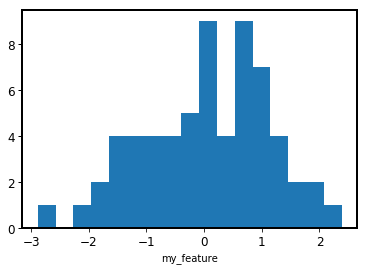

In [31]:
descriptor_index = 53
plt.hist(data_matrix[:, descriptor_index], bins=min([17, len(data_matrix)]), align='mid')
plt.xlabel(feature_names[descriptor_index])

Lets try and compare some of the features about atomic radii using violinplots.

Plotting:
10 vdw_radius_site_av
11 covalent_radius_cordero_site_av
14 atomic_radius_site_av


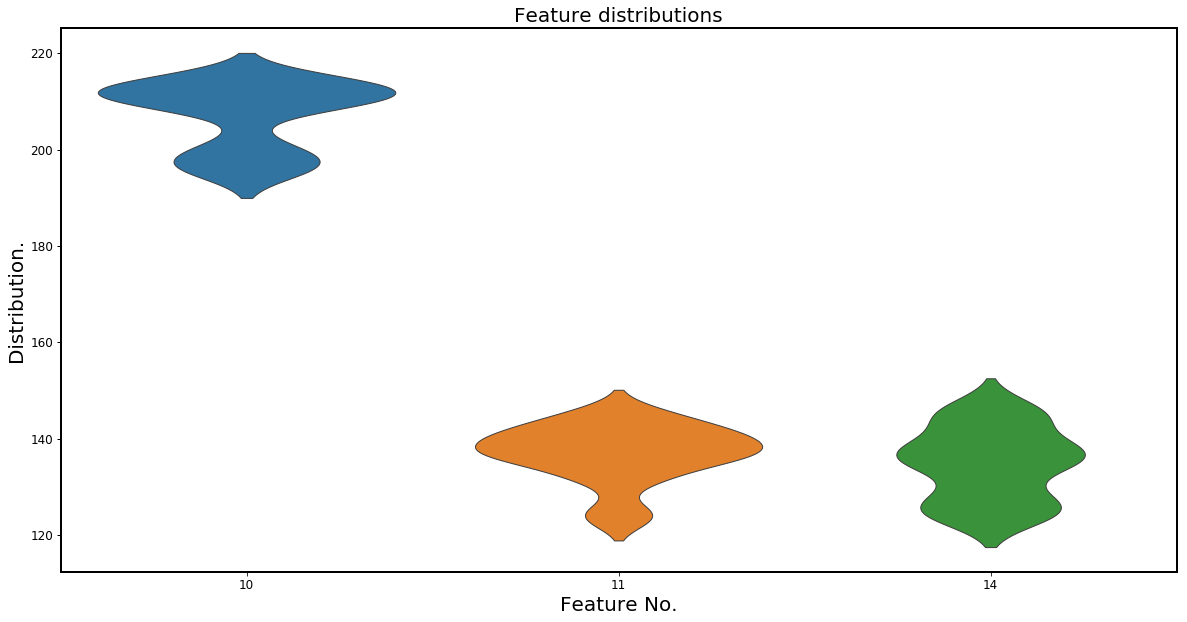

In [32]:
# Select some features to plot.
selection = [10, 11, 14]

# Plot selected of the feature distributions.
plot_data = {}
traint = np.transpose(data_matrix[:, selection])
for i, j in zip(traint, selection):
    plot_data[j] = i
df = pd.DataFrame(plot_data)
fig = plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=df, inner=None)
plt.title('Feature distributions', fontsize=20)
plt.xlabel('Feature No.', fontsize=20)
plt.ylabel('Distribution.', fontsize=20)

string = 'Plotting:'
for s in selection:
    string += '\n' + str(s) + ' ' + feature_names[s]
print(string)

### Clean data

In [33]:
from catlearn.preprocess.clean_data import clean_infinite, clean_variance

# Get rid of NaN's and Inf's
finite_data = clean_infinite(data_matrix, labels=feature_names)

# Get rid of features with identical values in all rows.
informative_data = clean_variance(finite_data['train'], labels=finite_data['labels'])

# Get the data matrix and list of labels.
training_data = informative_data['train']
clean_features = informative_data['labels']

### Correlations

Do a correlation analysis of the data.

Text(0,0.5,'Correlation')

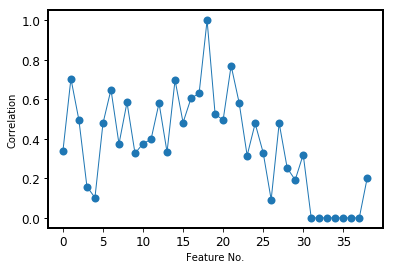

In [34]:
from catlearn.utilities.utilities import target_correlation, holdout_set

# Get the correlation of all features with one selected feature.
target_feature = 18
target_corr = target_correlation(training_data, training_data[:, target_feature], correlation=['pearson'])
plt.plot(list(range(np.shape(target_corr)[1])), np.abs(target_corr)[0, :], '-o')
plt.xlabel("Feature No.")
plt.ylabel("Correlation")

In [35]:
corr_ordering = np.argsort(np.abs(target_corr)[0, :])[::-1]
np.abs(target_corr)[0, corr_ordering]
print('Highest correlation with', clean_features[target_feature], ':\n')
for i in range(10):
    print(corr_ordering[i], clean_features[corr_ordering][i], np.abs(target_corr)[0, corr_ordering][i])

Highest correlation with dbcenter_site_av :

18 dbcenter_site_av 1.0
21 dbskew_site_av 0.7704728762315076
1 atomic_volume_site_av 0.7045987552623123
14 atomic_radius_site_av 0.6977168342869465
6 group_id_site_av 0.6490589948909845
17 dft_density_site_av 0.629425395491392
16 dft_bulk_modulus_site_av 0.6060927718911279
8 melting_point_site_av 0.5844646115762562
22 oxi_min_site_av 0.5826136045416407
12 en_allen_site_av 0.5810873299472212


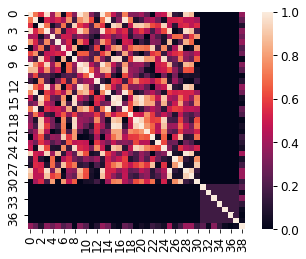

In [36]:
# Get correlation of all features with all features.

d = pd.DataFrame(training_data)
corr = d.corr(method='pearson')
sns.heatmap(corr.abs(), square=True)

In [37]:
# Look at a few selected feature pairs.
np.abs(target_corr)[0, :][31:36]

array([9.39843392e-18, 5.52849054e-19, 1.65854716e-18, 5.52849054e-19,
       3.53823394e-17])

In [38]:
# What are the labels of those.
clean_features[31:36]

array(['bag_ads_H', 'bag_ads_C', 'bag_ads_N', 'bag_ads_O', 'bag_ads_F'],
      dtype='<U31')

### Analysis of meta data.

Attached to the atoms objects, the fingerprinter needs information about the atoms belonging to the adsorbate. 
This was generate automatically by `autogen_info`, but we can take a closer look at how this meta data is formatted:

In [39]:
# Look at meta data for the first atoms object.
images[0].subsets

{'ads_atoms': [12],
 'slab_atoms': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'chemisorbed_atoms': [12],
 'site_atoms': [8, 9],
 'ligand_atoms': [4, 6, 7, 9, 10, 11, 5, 6, 7, 8, 10, 11],
 'bulk_atoms': [0, 1, 2, 3, 4, 5, 6, 7],
 'termination_atoms': [8, 9, 10, 11],
 'subsurf_atoms': [4, 5, 6, 7]}

E.g. Atomic indices of atoms belonging to the adsorbate are put in `atoms.subsets['ads_atoms']`
There is only one index in that subset, which shows that this system had a monoatomic adsorbate.

In [40]:
# Let's see which one it was.
print('adsorbate:', images[0].get_chemical_symbols()[12])

# What was the site?
print('site:', np.array(images[0].get_chemical_symbols())[images[0].subsets['site_atoms']])

adsorbate: H
site: ['Ag' 'Ag']


It was a H* sitting on a Ag-Ag bridge site.

As a user, you can always choose to attach this information and avoid relying on `autogen_info`, if you prefer. There could be various reasons, why the accuracy of `autogen_info` is not always optimal.

`autogen_info` will respect any subsets already present.

Furthermore `autogen_info` builds the subsets using information from a connectivity matrix that is stored in `atoms.connectivity`. If the atoms object already has `atoms.connectivity`, that will be kept and used, otherwise a new one will be created using default cutoffs for neighbor distances.

In [41]:
# Lets look at a connectivity matrix.
images[0].connectivity

array([[0, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [2, 2, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0],
       [2, 2, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 0, 2, 2, 2, 1, 0, 1, 1, 0],
       [1, 1, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 2, 2, 0, 2, 1, 1, 1, 0, 0],
       [1, 0, 1, 1, 2, 2, 2, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 2, 2, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 2, 2, 1],
       [0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 2, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 2, 2, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]])

Note that there are some 2's in there. Those are a result of the small unit cell size, where atoms can connect to neighbors in several neighboring unit cells.

# ASE Database interface
ASE database is a very useful format for small to medium size (up to around 100000) sets of atomic structures. Here we will create an ASE db file and redo the import from the db.

In [42]:
import ase.db
from catlearn.api.ase_atoms_api import database_to_list
from catlearn.featurize.adsorbate_prep import autogen_info

In [43]:
# Create a new ASE db.
fname = 'ads_example.db'
os.remove(fname)
c = ase.db.connect(fname)

# Write our atoms objects to the ASE db.
for atoms in images:
    symbols=atoms.get_chemical_symbols()
    species=symbols[atoms.subsets['ads_atoms'][0]]
    name=symbols[atoms.subsets['slab_atoms'][0]]
    c.write(atoms,
            # Recommended keys for CatLearn.
            species=species,
            # Recommended keys for CatMAP compatibility.
            name=name,
            facet='(111)', n=1, crystal='fcc', supercell='2x2', layers=3, surf_lattice='hexagonal')

In [44]:
# Import data.
images = database_to_list(fname)

From here you can run `autogen_info` and the following workflow, as presented before.

# Analyse bond distances, check cutoffs

This analysis must be done on optimized structures, but here we show a toy example using the dataset introduced previously in this tutorial.

In the following, we will plot pair distribution functions (pdf) over our dataset or subset. This is necessary to convince ourselves that a we can rely on connectivities to fingerprint the atomic structures. 

In [45]:
from ase.data import covalent_radii
from catlearn.utilities.distribution import pair_distribution, pair_deviation

### Pair distribution function
The pair distribution function is a histrogram over distances between the atoms in our dataset. Our pdf utility in catlearn can optionally select a one or two elements to include in the analysis.

In [46]:
# int for bonds between a single element and all other atoms. 
# tuple (A, B) for bonds between A and B only.
element = 6

images_subset = [a for a in images if element in a.numbers]

# Generate pdf.
pdf, x = pair_distribution(images_subset, bins=257, bounds=(0.3, 3.), element=element)

Text(0.5,0,'$r$ [$10^{-10}$ m]')

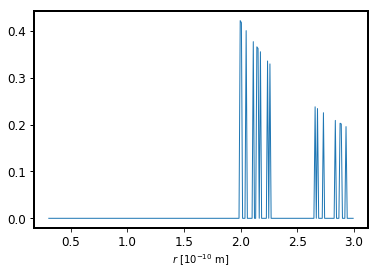

In [47]:
# Plot pdf.
plt.plot(x, pdf)
plt.xlabel('$r$ [$10^{-10}$ m]')

The pdf does not directly show us the appropriate cutoff unless we select a specific pair of elements to count bonds between.

### Set cutoffs

Lets set some cutoffs manually and evaluate them.

In [48]:
cutoff_dictionary = {}
for z, s in enumerate(chemical_symbols[:104]):
    if z == 0:
        continue
    elif s in adsorbates and z!=1:
        radius = covalent_radii[z] * 1.1 + 0.1
    else:
        radius = get_radius(z) * 1.1 + 0.1
    cutoff_dictionary[z] = radius

In [49]:
# int for bonds between a single element and all other atoms. 
# tuple (A, B) for bonds between A and B only.
element = (78, 1)

images_subset = [a for a in images if element[0] in a.numbers and element[1] in a.numbers]

# Generate pdf.
pdf, x = pair_distribution(images_subset, bins=257, bounds=(0.3, 3.), element=element)

Pt cutoff radius 1.629
H cutoff radius 0.9690000000000001
bond cutoff 2.598


Text(0.5,0,'$r$ [$10^{-10}$ m]')

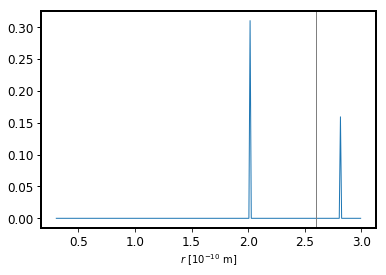

In [50]:
# Plot pdf.
plt.plot(x, pdf)

# Print and plot bond lenght
bond = 0.
if isinstance(element, int):
    print(chemical_symbols[element] + ' cutoff radius', cutoff_dictionary[element])
elif isinstance(element, tuple):
    for z in element:
        print(chemical_symbols[z] + ' cutoff radius', cutoff_dictionary[z])
        bond += cutoff_dictionary[z]
    print('bond cutoff', bond)
plt.axvline(bond, color='0.5')

# Axis label.
plt.xlabel('$r$ [$10^{-10}$ m]')

If the line is after the first peak and clear of any other peaks, the cutoff will clearly distinguish first nearest neigbors.

### Check cutoffs

When our dataset has a larger number of elements, we don't really want to evaluate every pair of elements as shown above. We can instead plot a histogram of bond distances, where the element specific cutoff radii have been subtracted, $r - (r_a + r_b)$.

In [51]:
deviation, xd = pair_deviation(images, bins=257, bounds=(-.75, 0.75), cutoffs=cutoff_dictionary)

Text(0.5,0,'$r - (r_a + r_b)$ [$10^{-10}$ m]')

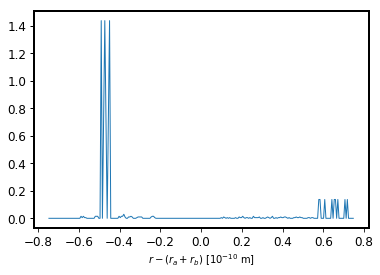

In [52]:
plt.plot(xd, deviation)
plt.xlabel('$r - (r_a + r_b)$ [$10^{-10}$ m]')

If the distribution is 0 where $r = r_a + r_b$, we can unambigously represent structures by their connectivity. If the distribution is not 0 at $r = r_a + r_b$, we may be able to tune our cutoff radii to obtain more accurate connectivities, depending on the dataset.